In [1]:
import pandas as pd

In [2]:
# pd.options.plotting.backend = "plotly"

In [3]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt 
from sklearn.ensemble import GradientBoostingRegressor

In [4]:
from tqdm import tqdm_notebook as tqdm

In [5]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

In [6]:
# %matplotlib inline

In [7]:
 
import numpy as np
plt.rcParams['figure.figsize'] = (16, 4)

In [8]:
import warnings
warnings.filterwarnings(action="ignore")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [9]:
from utils import * # We've added all the functions from the last BLU to the utils.py 

In [10]:
from xgboost import XGBRegressor

# DATA

In [11]:
df = pd.read_csv("data/data.csv", index_col="date", parse_dates=True)

In [55]:
df=df['2017':]

In [56]:
train = df.iloc[:-24*7]
test = df.iloc[-24*7:]

In [57]:
from sklearn.impute import KNNImputer
imputer = KNNImputer() # To obtain better results we may want to have more neighbors, of course that in a real setting
                       # this is a parameter that should be tunned
    
imputed_train = imputer.fit_transform(train) # This may take a bit to run
train = pd.DataFrame(imputed_train, index=train.index, columns=train.columns)

In [58]:
df=pd.concat([train,test], axis=0)

In [59]:
df

,PM2.5,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead159,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,485.0,1.0,0.7,1.1,1.1,1.0,0.8,1.2,1.0,0.9,...,1.1,1.4,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7
2017-01-01 01:00:00,477.0,0.7,1.1,1.1,1.0,0.8,1.2,1.0,0.9,1.0,...,1.4,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5
2017-01-01 02:00:00,454.0,1.1,1.1,1.0,0.8,1.2,1.0,0.9,1.0,0.9,...,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2
2017-01-01 03:00:00,418.0,1.1,1.0,0.8,1.2,1.0,0.9,1.0,0.9,0.9,...,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2,1.8
2017-01-01 04:00:00,438.0,1.0,0.8,1.2,1.0,0.9,1.0,0.9,0.9,0.9,...,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2,1.8,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-21 19:00:00,NaN,1.4,1.5,1.1,1.7,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-21 20:00:00,NaN,1.5,1.1,1.7,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-02-21 21:00:00,NaN,1.1,1.7,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:
df = build_exog_features(df, 24*7)

In [61]:
train = df.iloc[:-24*7*2]
val = df.iloc[-24*7*2:-24*7]
train_val = df.iloc[:-24*7]
test = df.iloc[-24*7:]

# VALIDATION

In [62]:
train

,PM2.5,exog,exog_lead1,exog_lead2,exog_lead3,exog_lead4,exog_lead5,exog_lead6,exog_lead7,exog_lead8,...,exog_lead159,exog_lead160,exog_lead161,exog_lead162,exog_lead163,exog_lead164,exog_lead165,exog_lead166,exog_lead167,exog_lead168
date,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,485.0,1.0,0.7,1.1,1.1,1.0,0.8,1.2,1.0,0.9,...,1.1,1.4,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7
2017-01-01 01:00:00,477.0,0.7,1.1,1.1,1.0,0.8,1.2,1.0,0.9,1.0,...,1.4,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5
2017-01-01 02:00:00,454.0,1.1,1.1,1.0,0.8,1.2,1.0,0.9,1.0,0.9,...,1.5,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2
2017-01-01 03:00:00,418.0,1.1,1.0,0.8,1.2,1.0,0.9,1.0,0.9,0.9,...,1.1,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2,1.8
2017-01-01 04:00:00,438.0,1.0,0.8,1.2,1.0,0.9,1.0,0.9,0.9,0.9,...,0.1,0.9,0.6,1.0,0.0,1.7,1.5,2.2,1.8,2.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-02-07 19:00:00,110.0,1.2,1.3,0.8,0.4,0.0,0.2,0.0,1.2,1.7,...,1.4,1.4,1.9,1.3,1.3,1.3,2.0,1.7,1.2,1.1
2017-02-07 20:00:00,118.0,1.3,0.8,0.4,0.0,0.2,0.0,1.2,1.7,1.6,...,1.4,1.9,1.3,1.3,1.3,2.0,1.7,1.2,1.1,0.2
2017-02-07 21:00:00,107.0,0.8,0.4,0.0,0.2,0.0,1.2,1.7,1.6,1.8,...,1.9,1.3,1.3,1.3,2.0,1.7,1.2,1.1,0.2,1.0


In [66]:
predictions = predict_n_periods(series_=train, 
                  n_periods=24*7, 
                  model=LinearRegression(), 
                  num_periods_lagged=24*7,
                  num_periods_diffed=24,
                  weekday = True,
                  month = True,
                  hour=True,
                  holidays = False,
                  target = "PM2.5"
                  )

  0%|          | 0/168 [00:00<?, ?it/s]

In [67]:
val_mae = mean_absolute_error(val["PM2.5"],predictions)
print(val_mae)

2556688.675804789


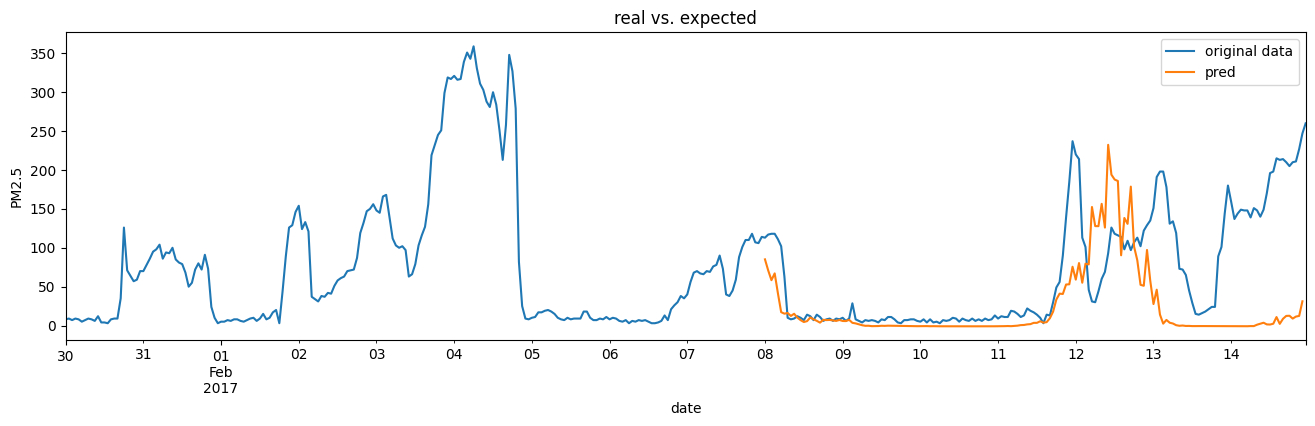

In [65]:
train_val.loc["2017-01-30":"2017-02-14"]["PM2.5"].plot(label="original data")
plt.ylabel('PM2.5')
pd.Series(np.exp(predictions)-1, index=val.index).plot(label="pred")
plt.title('real vs. expected')
plt.legend();

In [40]:
predictions_submission_log = predict_n_periods(series_=np.log(train_val+1), 
                  n_periods=24*7, 
                  model=LinearRegression(), 
                  num_periods_lagged=24*7,
                  num_periods_diffed=24,
                  weekday = True,
                  month = True,
                  hour=True,
                  holidays = False,
                  target = "PM2.5"
                  )

Period 1
Fitting...
Period 2
Fitting...
Period 3
Fitting...
Period 4
Fitting...
Period 5
Fitting...
Period 6
Fitting...
Period 7
Fitting...
Period 8
Fitting...
Period 9
Fitting...
Period 10
Fitting...
Period 11
Fitting...
Period 12
Fitting...
Period 13
Fitting...
Period 14
Fitting...
Period 15
Fitting...
Period 16
Fitting...
Period 17
Fitting...
Period 18
Fitting...
Period 19
Fitting...
Period 20
Fitting...
Period 21
Fitting...
Period 22
Fitting...
Period 23
Fitting...
Period 24
Fitting...
Period 25
Fitting...
Period 26
Fitting...
Period 27
Fitting...
Period 28
Fitting...
Period 29
Fitting...
Period 30
Fitting...
Period 31
Fitting...
Period 32
Fitting...
Period 33
Fitting...
Period 34
Fitting...
Period 35
Fitting...
Period 36
Fitting...
Period 37
Fitting...
Period 38
Fitting...
Period 39
Fitting...
Period 40
Fitting...
Period 41
Fitting...
Period 42
Fitting...
Period 43
Fitting...
Period 44
Fitting...
Period 45
Fitting...
Period 46
Fitting...
Period 47
Fitting...
Period 48
Fitting...
P

In [43]:
predictions_submission_exp=(np.exp(predictions_submission_log)-1)

In [44]:
submission=pd.DataFrame(predictions_submission_exp, columns=["PM2.5"])

In [45]:
submission.to_csv("data/submission_4_lr.csv", index=False)